In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


In [39]:
trainloader = None
testloader = None
def fetchData(normalize=False, bs=32):
  transform = None
  if normalize:
    transform = transforms.Compose(
        [transforms.ToTensor(),transforms.Normalize( (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
  else:
    transform = transforms.Compose(
        [transforms.ToTensor()])
  trainset = torchvision.datasets.CIFAR10(root='CA5-CIFAR-10-train', 
                                        train=True,
                                        download=True,
                                        transform = transform)
  trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=bs,
                                          shuffle=True)

  testset = torchvision.datasets.CIFAR10(root='CA5-CIFAR-10-test', 
                                       train=False,
                                       download=True,
                                       transform = transform)
  testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=bs,
                                         shuffle=False)
  return trainloader, testloader

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')
trainloader, testloader = fetchData(False, 32)

Files already downloaded and verified
Files already downloaded and verified


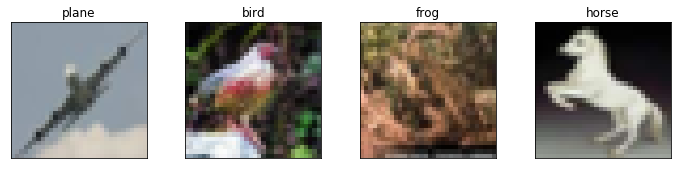

In [8]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
#     image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images[:4]), figsize=(12,2.5))
for idx, image in enumerate(images[:4]):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])


1)

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8*8*128, 10),
#             nn.ReLU(inplace=True),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.1),
#             nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x


net = Net()
net.to(device)
def init_weights_zero(m):
  if type(m) == nn.Linear or type(m) == nn.Conv2d:
    nn.init.constant_(m.weight, 0)
    m.bias.data.fill_(0)
    
def findAccuracy():
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the ',total,' test images: %.2f%%' % (
      100 * correct / total))
  
def trainNet():
  lossList = []
  start = int(round(time.time() * 1000))
  for epoch in range(5):  # loop over the dataset multiple times

#       running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device) 
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
#           running_loss += loss.item()
          lossList.append(loss.item())
#           if i % 250 == 249:    # print every 2000 mini-batches
#               print('[%d, %5d] loss: %.3f' %
#                     (epoch + 1, i + 1, running_loss / 250))
#               running_loss = 0.0

  print('Finished Training in ', int(round(time.time() * 1000))-start, " ms")
  return lossList

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print('without init')
trainNet()
findAccuracy()
net = Net()
net.apply(init_weights_zero)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print('init_weights_zero')
trainNet()
findAccuracy()

without init
Finished Training in  61683  ms
Accuracy of the network on the  10000  test images: 71.84%
init_weights_zero
Finished Training in  60931  ms
Accuracy of the network on the  10000  test images: 10.00%


In [48]:
net = Net()
def init_weights_random(m):
  if type(m) == nn.Conv2d:
    m.weight.data = torch.rand(m.weight.size(0),m.weight.size(1),m.weight.size(2),m.weight.size(3)) +\
    (torch.zeros(m.weight.size(0),m.weight.size(1),m.weight.size(2),m.weight.size(3)) * m.weight)
    m.bias.data = torch.rand(m.bias.size(0)) + (torch.zeros(m.bias.size(0)) * m.bias) 
    return
  if type(m) == nn.Linear:
    m.weight.data = torch.rand(m.weight.size(0),m.weight.size(1)) +\
    (torch.zeros(m.weight.size(0),m.weight.size(1)) * m.weight)
    m.bias.data = torch.rand(m.bias.size(0)) + (torch.zeros(m.bias.size(0)) * m.bias)
    return
  
net.apply(init_weights_random)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print('init_weights_random')
trainNet()
findAccuracy()

init_weights_random
Finished Training in  61683  ms
Accuracy of the network on the  10000  test images: 22.87%


2)

In [42]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(16*16*256, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x


net = Net2()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print('without init')
trainNet()
findAccuracy()
net = Net2()
net.apply(init_weights_zero)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print('init_weights_zero')
trainNet()
findAccuracy()
net = Net2()
net.apply(init_weights_random)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print('init_weights_random')
trainNet()
findAccuracy()


without init
Finished Training in  65928  ms
Accuracy of the network on the  10000  test images: 64 %
init_weights_zero
Finished Training in  64265  ms
Accuracy of the network on the  10000  test images: 10 %
init_weights_random
Finished Training in  64597  ms
Accuracy of the network on the  10000  test images: 25 %


3)

In [43]:
trainloader, testloader = fetchData(False, 32)
print('whitout normalization')
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
trainNet()
findAccuracy()
trainloader, testloader = fetchData(True, 32)
print('normalize')
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
trainNet()
findAccuracy()

Files already downloaded and verified
Files already downloaded and verified
whitout normalization
Finished Training in  50779  ms
Accuracy of the network on the  10000  test images: 73 %
Files already downloaded and verified
Files already downloaded and verified
normalize
Finished Training in  61236  ms
Accuracy of the network on the  10000  test images: 73 %


4)

Files already downloaded and verified
Files already downloaded and verified
lr :  0.01
Finished Training in  61208  ms
Accuracy of the network on the  10000  test images: 74 %
Files already downloaded and verified
Files already downloaded and verified
lr :  0.0001
Finished Training in  61459  ms
Accuracy of the network on the  10000  test images: 65 %


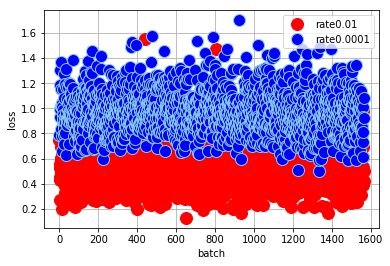

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

trainloader, testloader = fetchData(True, 32)
print('lr : ', 0.01)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
lossList = trainNet()
findAccuracy()
trainloader, testloader = fetchData(True, 32)
print('lr : ', 0.0001)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
lossList2 = trainNet()
findAccuracy()
xlist = lossList[(len(lossList)-(int(len(lossList)/5))):]
df=pd.DataFrame({'x': range(1,len(xlist)+1),\
'rate0.01': lossList[(len(lossList)-(int(len(lossList)/5))):],\
'rate0.0001': lossList2[(len(lossList2)-(int(len(lossList2)/5))):]})
plt.plot( 'x', 'rate0.01', data=df, marker='o', markerfacecolor='red', markersize=12, color='red', linewidth=0)
plt.plot( 'x', 'rate0.0001', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=0)
plt.xlabel('batch')
plt.ylabel('loss')
plt.grid()
plt.legend()

5)

In [45]:
trainloader, testloader = fetchData(True, 32)
print('batch size : ', 32, 'lr: ', 0.001)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
trainNet()
findAccuracy()
print('batch size : ', 32, 'lr: ', 0.01)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainNet()
findAccuracy()
print('batch size : ', 32, 'lr: ', 0.0001)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
trainNet()
findAccuracy()

trainloader, testloader = fetchData(True, 64)
print('batch size : ', 64, 'lr: ', 0.001)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
trainNet()
findAccuracy()
print('batch size : ', 64, 'lr: ', 0.01)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainNet()
findAccuracy()
print('batch size : ', 64, 'lr: ', 0.0001)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
trainNet()
findAccuracy()

trainloader, testloader = fetchData(True, 256)
print('batch size : ', 256, 'lr: ', 0.001)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
trainNet()
findAccuracy()
print('batch size : ', 256, 'lr: ', 0.01)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainNet()
findAccuracy()
print('batch size : ', 256, 'lr: ', 0.0001)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
trainNet()
findAccuracy()

Files already downloaded and verified
Files already downloaded and verified
batch size :  32 lr:  0.001
Finished Training in  61695  ms
Accuracy of the network on the  10000  test images: 73 %
batch size :  32 lr:  0.01
Finished Training in  61315  ms
Accuracy of the network on the  10000  test images: 75 %
batch size :  32 lr:  0.0001
Finished Training in  61629  ms
Accuracy of the network on the  10000  test images: 65 %
Files already downloaded and verified
Files already downloaded and verified
batch size :  64 lr:  0.001
Finished Training in  71352  ms
Accuracy of the network on the  10000  test images: 70 %
batch size :  64 lr:  0.01
Finished Training in  71190  ms
Accuracy of the network on the  10000  test images: 75 %
batch size :  64 lr:  0.0001
Finished Training in  71407  ms
Accuracy of the network on the  10000  test images: 60 %
Files already downloaded and verified
Files already downloaded and verified
batch size :  256 lr:  0.001
Finished Training in  73793  ms
Accuracy 

6)

In [56]:
class NetTanh(nn.Module):
    def __init__(self):
        super(NetTanh, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8*8*128, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x
      
class NetLeakyReLU(nn.Module):
    def __init__(self):
        super(NetLeakyReLU, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8*8*128, 10)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x
      
class NetSoftplus(nn.Module):
    def __init__(self):
        super(NetSoftplus, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Softplus(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8*8*128, 10)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x



trainloader, testloader = fetchData(True, 32)
print('relu')
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainNet()
findAccuracy()
print('tanh')
net = NetTanh()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainNet()
findAccuracy()
print('leaky relu')
net = NetLeakyReLU()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainNet()
findAccuracy()
print('softplus')
net = NetSoftplus()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainNet()
findAccuracy()

Files already downloaded and verified
Files already downloaded and verified
relu
Finished Training in  61658  ms
Accuracy of the network on the  10000  test images: 73.69%
tanh
Finished Training in  61866  ms
Accuracy of the network on the  10000  test images: 70.15%
leaky relu
Finished Training in  61439  ms
Accuracy of the network on the  10000  test images: 75.05%
softplus
Finished Training in  61864  ms
Accuracy of the network on the  10000  test images: 65.31%


7)

In [57]:
trainloader, testloader = fetchData(True, 32)
print('leaky relu')
net = NetLeakyReLU()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainNet()
findAccuracy()
trainloader, testloader = fetchData(True, 32)
print('leaky relu without momentum')
net = NetLeakyReLU()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
trainNet()
findAccuracy()


Files already downloaded and verified
Files already downloaded and verified
leaky relu
Finished Training in  61096  ms
Accuracy of the network on the  10000  test images: 75.12%
Files already downloaded and verified
Files already downloaded and verified
leaky relu without momentum
Finished Training in  60797  ms
Accuracy of the network on the  10000  test images: 69.50%
